# Terrain Classification - Compare Window Size

In [39]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import sklearn
import numpy as np

#### Data Structure

`Dictionary of Window Sizes
-> Dictionary of Feature Vectors
---> Dictionary of Placements
-----> Dataframe of Processed Data`

In [72]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

# Dictionary of classifiers
classifiers = {'Naive Bayes': GaussianNB(),               'k Nearest': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier(n_estimators=100),
               'AdaBoost': AdaBoostClassifier(),          'Support Vector Machine': SVC()}

In [67]:
# Initialize data structure of imported data
size_values = [50, 100, 200, 300, 400, 500]
placements = {'Left': None, 'Middle': None, 'Right': None}
vectors = {vector: placements for vector in ['Features', 'FFTs', 'PSDLogs']}
sizes = {size: vectors for size in size_values}

# For each .csv of processed data
for filename in glob.glob('processed_data/windows/*.csv'):
    placement, vector, size = filename.split('/')[-1].split('.')[0].split('_')
    data = pd.read_csv(filename)
    labels = data.pop('Label')
    
    # Save as tuple of data and labels
    sizes[int(size)][vector][placement] = (data, labels)

In [70]:
classifier_metrics = {name: [] for name in classifiers.keys()}

'''Train classifiers on all sizes and save metrics'''

def train_sizes(cv_value=5):
    # Figure properties
    fig = plt.subplots(figsize=(10, 8))
    plt.title('Window Size Comparision for ' + placement + ' ' + vector)
    plt.xlabel('Window Size')
    plt.ylabel(metric)
    
    # For each window size
    for size_value in size_values:
        # Split labels from data
        size_data, size_labels = sizes[size_value][vector][placement]
        
        for name in classifier_names:
            # Update classifier model
            model = classifiers[name]
            
            # Get preferred metric through mean of five cross validations
            # Metrics = 'fit_time', 'score_time', 'test_score', 'train_score'
            result = cross_validate(model, size_data, size_labels, cv=cv_value, 
                                            return_train_score=True)
            classifier_metrics[name].append(result)
    
    for name, metric in classifier_metrics.items():
        plt.plot(size_values, metric, label=name)
    
    plt.legend()
    plt.show()

In [ ]:
placement, vector, 

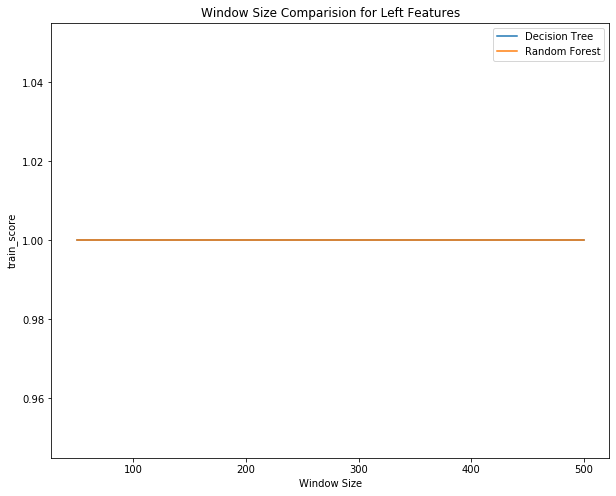

In [73]:
compare_sizes('Left', 'Features', ['Decision Tree', 'Random Forest'], 'train_score')

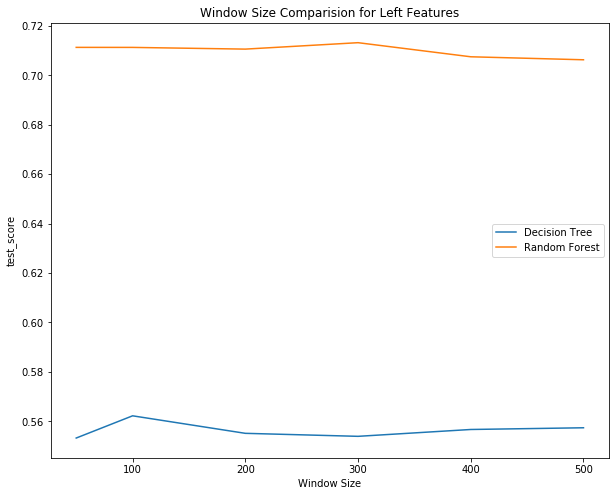

In [76]:
compare_sizes('Left', 'Features', ['Decision Tree', 'Random Forest'], 'test_score')

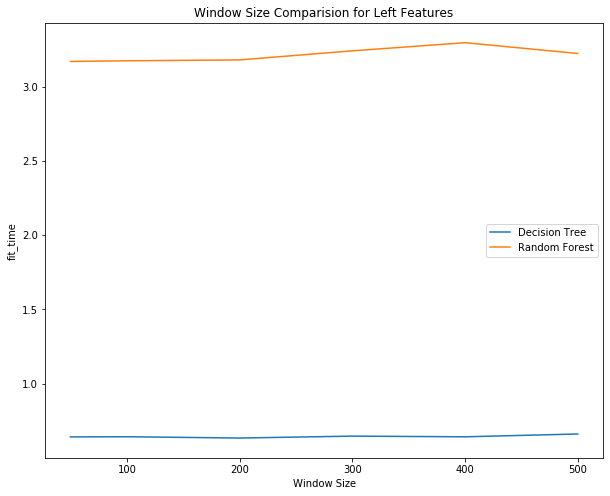

In [75]:
compare_sizes('Left', 'Features', ['Decision Tree', 'Random Forest'], 'fit_time')

In [ ]:
compare_sizes('Left', 'Features', ['Decision Tree', 'Random Forest'], 'score_time')